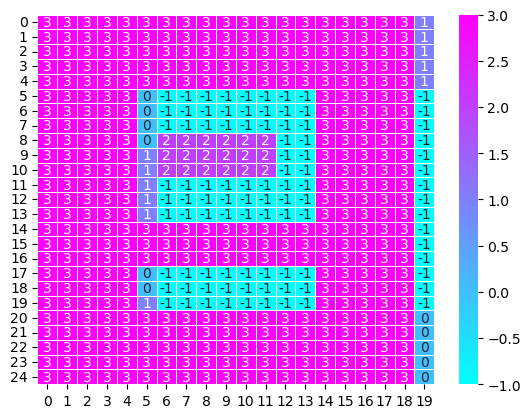

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

expert = np.load('expert_map.npy')

fig, ax = plt.subplots()
ax = sns.heatmap(expert, annot=True, fmt=".2g", cmap='cool', linewidths=.5)
plt.show()


Create your own expert map

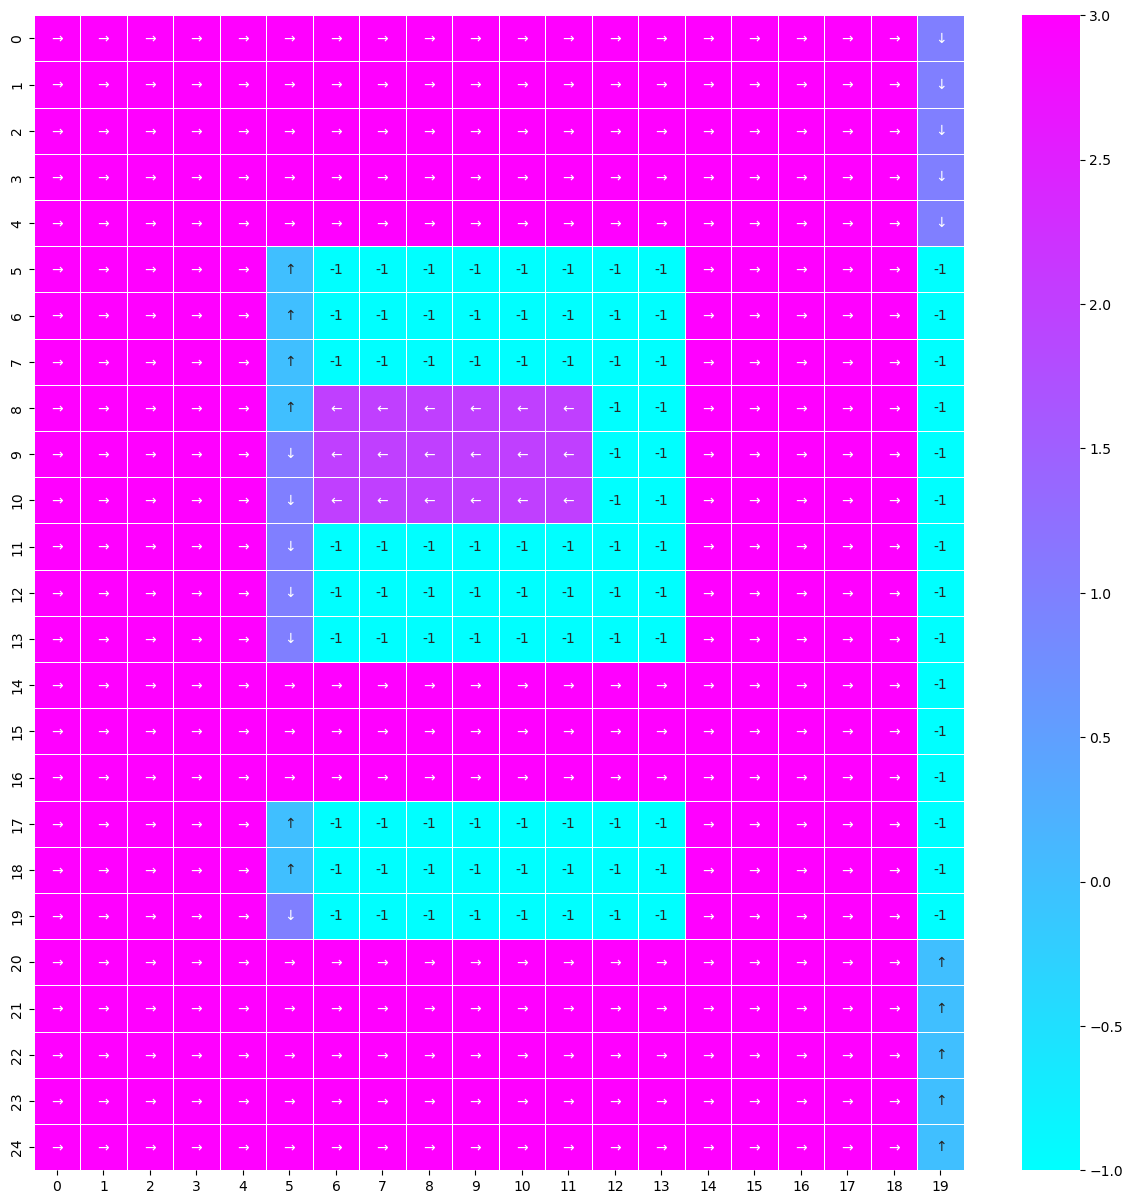

⮉


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

grid = np.full((25,20), 3)

grid[5:14, 6:14] = -1
grid[8:11, 6:12] = 2
grid[17:20, 6:14] = -1
grid[5:20, 19] = -1

grid[5:9, 5] = 0
grid[9:14, 5] = 1
grid[:5, 19] = 1
grid[20:, 19] = 0
grid[17:19, 5] = 0
grid[19,5] = 1

num_to_arrow = {0: u'\u2191', 1: u'\u2193', 2: u'\u2190', 3: u'\u2192', -1:'-1'}
f = np.vectorize(lambda x: num_to_arrow[x])
arrows = f(grid)

fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(grid, annot=arrows, fmt="s", cmap='cool', linewidths=.5)
plt.show()

np.save('expert_map.npy', grid)

print(u'\u2B89')

In [1]:
from neural_model import NeuralNet
import torch
import torch.nn as nn
import torch.functional as F

s = [torch.randn((128, 1, 5, 5)), torch.rand((128, 2))]
net = NeuralNet()
out = net(s)

c:\Users\siddh\anaconda3\envs\deeprobot\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([128, 12])
torch.Size([128, 8])


[ 10  20  30  40  50  60  70  80  90 100 102]
[5.2, 3.3, 3.2, 3.6, 4.0, 3.7, 4.0, 4.3, 4.6, 4.2, 5.5]


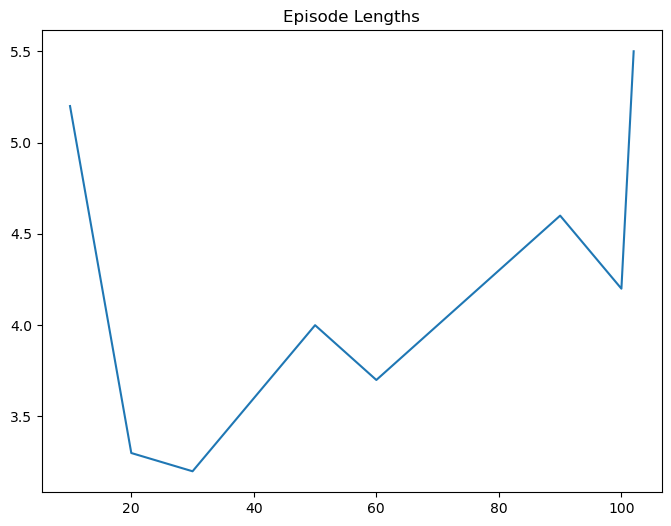

In [1]:
import numpy as np
import matplotlib.pyplot as plt

ep_lenghts = np.random.randint(0, 10, size=103)
smoothing_number = 10

x = np.arange(0, len(ep_lenghts), smoothing_number)
x = np.append(x, len(ep_lenghts)-1)
y = [np.average(ep_lenghts[x[i]:x[i+1]]) for i in range(len(x)-1)]
x = x[1:]
print(x)
print(y)

fig, ax0 = plt.subplots(figsize=(8,6))
ax0.set_title('Episode Lengths')
ax0.plot(x, y)
plt.show()

Meshgrid

In [14]:
import numpy as np

m = np.mgrid[0:15, 0:20]
# print(m.shape)

inds = np.stack((m[0], m[1]), axis=2)

# starts = list(inds[:, 4:6]) + list(inds[:, 14:16])
starts = inds[:, 14:16]
# print(starts)

inds = [[i, j] for i in range(15) for j in [14,15]]
print(inds)

[[0, 14], [0, 15], [1, 14], [1, 15], [2, 14], [2, 15], [3, 14], [3, 15], [4, 14], [4, 15], [5, 14], [5, 15], [6, 14], [6, 15], [7, 14], [7, 15], [8, 14], [8, 15], [9, 14], [9, 15], [10, 14], [10, 15], [11, 14], [11, 15], [12, 14], [12, 15], [13, 14], [13, 15], [14, 14], [14, 15]]


Evaluate models

In [33]:
import torch
import numpy as np
import os
from sparse_env import Grid
from dqn import DQN_Agent, QNet, MNet, VNet

env = Grid(patch_size=5, expert_map_f='expert_map.npy')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


Q = QNet(device, 1e-4, '15k/v5/')
Q.load_model('15k/v5/models/Qmodel.pth')
M = MNet(device, 1e-4, '15k/v5/')
M.load_model('15k/v5/models/Mmodel.pth')
V = VNet(device, 1e-4, '15k/v5/')
V.load_model('15k/v5/models/Vmodel.pth')

Q.model.eval()
M.model.eval()
V.model.eval()

rows, cols = np.indices((15,13))
rows = rows.reshape(-1)
cols = cols.reshape(-1)
posns = np.stack((rows, cols), axis=1)

# Will give a list of 210 elements, each having the patch and posn of all cells in the grid
all_states = list(map(lambda x: env.yx_to_obs(x), posns))

# Will convert all patches and posns into one tensor each to be passed to the models
all_patches, all_posns = map(lambda x: torch.from_numpy(np.stack(x)).to(device), \
                            zip(*all_states))

# [Tensor_of_shape(210, 4, 3, 3), Tensor_of_shape(210, 2)]
all_state_tensors = [all_patches.float(), all_posns.float()]

# Q values and best actions
qvalues = Q.model(all_state_tensors)
best_actions = torch.argmax(qvalues, axis=1).reshape(-1)

# Plotting Best actions
best_actions_map = np.zeros((15,13))
best_actions_map[rows, cols] = best_actions.cpu().numpy()

# These states either have obstacles, traps or goals and their best action values
# do not make any sense. Will be set to -1 to avoid confusion
obstacle_x, obstacle_y = np.where(env.grid!=0)
best_actions_map[obstacle_x, obstacle_y] = -1

# Plotting Variances of every state
variances = V.model(all_state_tensors)
mvalues = M.model(all_state_tensors)


qvalues = qvalues.reshape(15,13,4)
mvalues = mvalues.reshape(15,13,4)
variances = variances.reshape(15,13,4)




print(qvalues[5,6])
print(mvalues[5,6])
print(variances[5,6])







tensor([-2.8319, -3.3365, -2.5845, -4.5445], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([1.4274, 0.5258, 2.0245, 2.4394], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.8763, -0.9781, -0.6084, -1.5651], device='cuda:0',
       grad_fn=<SelectBackward0>)


Using check_model_values to print the Q, M, V values at a particular grid cell

In [2]:
from dqn import DQN_Agent
from sparse_env import Grid
import torch
import os
os.chdir('/home/sidd/Human-in-the-loop-RL/')
print(os.getcwd())

print(os.path.isdir('DQN_sparse_map/Ocean/20k/v2/alg1/models'))

env = Grid(patch_size=5, expert_penalty=-5)
test_env = Grid(0, patch_size=5)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
lr = 1e-4			# Learning rate for Q, M models

DQN = DQN_Agent(env, test_env, lr, device)
DQN.check_model_values('DQN_sparse_map/Ocean/20k/v7/alg1/models', [3,10], alg2=False)
DQN.check_model_values('DQN_sparse_map/Ocean/20k/v8/alg1/models', [3,10], alg2=False)


/home/sidd/Human-in-the-loop-RL
True
DQN Initialized
m, and n are:  11 16
shape of all_state_tensors:  torch.Size([176, 1, 5, 5]) torch.Size([176, 2])
Q Values: tensor([-10.1215,  -9.5636,  -7.8181,  -5.6934, -12.5862], device='cuda:0',
       grad_fn=<SelectBackward0>)
m, and n are:  11 16
shape of all_state_tensors:  torch.Size([176, 1, 5, 5]) torch.Size([176, 2])
Q Values: tensor([-10.1215,  -9.5636,  -7.8181,  -5.6934, -12.5862], device='cuda:0',
       grad_fn=<SelectBackward0>)


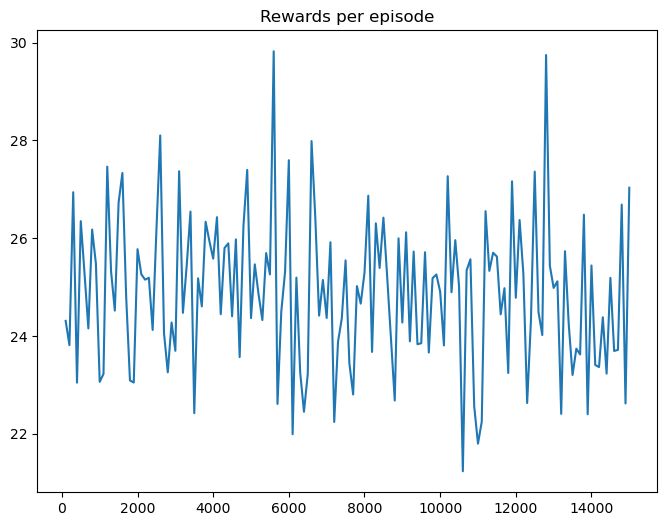

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizations
# Plotting Rewards
ep_rewards = np.random.uniform(0, 50, size=15000)

smoothing_number = 100
x = np.arange(0, len(ep_rewards), smoothing_number)
x = np.append(x, len(ep_rewards))
y = [np.average(ep_rewards[x[i]:x[i+1]]) for i in range(len(x)-1)]
x = x[1:]

fig, ax0 = plt.subplots(figsize=(8,6))
ax0.set_title('Rewards per episode')
ax0.plot(x, y)
# plt.savefig(os.path.join(self.logdir, 'Plots', 'rewards.jpg'), \
#     bbox_inches ="tight",\
#     dpi=250)
plt.show()

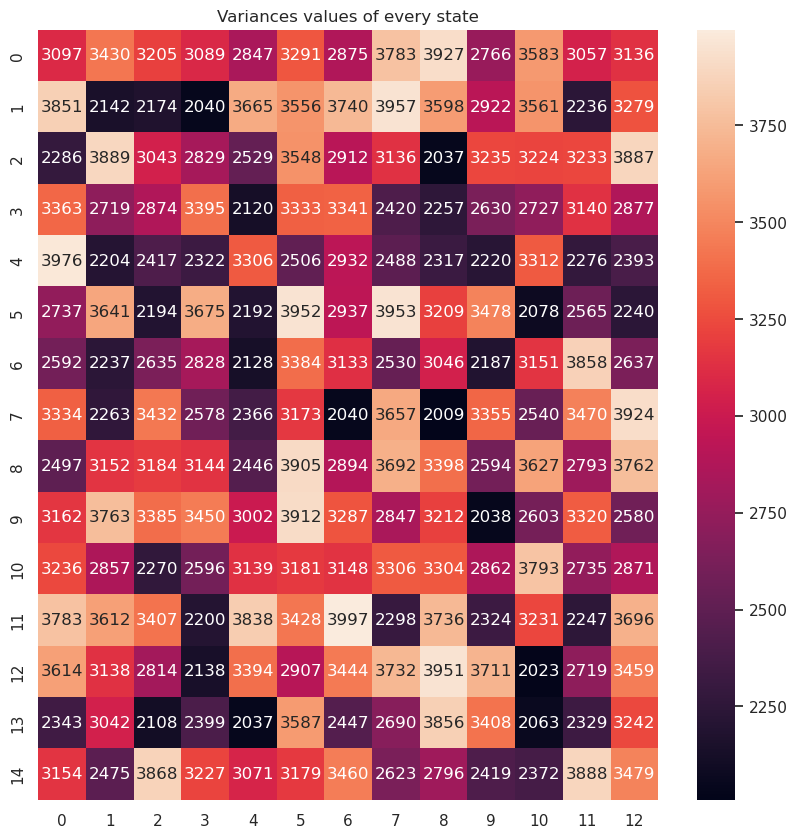

In [2]:
import numpy as np; np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()



fig, ax = plt.subplots(figsize=(10,10))
sns.set_palette("mako", 10)
uniform_data = np.random.uniform(2000.0, 4000.0, size=(15,13)).astype(int)
ax.set_title('Variances values of every state')
ax = sns.heatmap(uniform_data,annot=True, fmt=".0f")
plt.savefig('delete_plot.jpg')

Print out weights in a particular layer

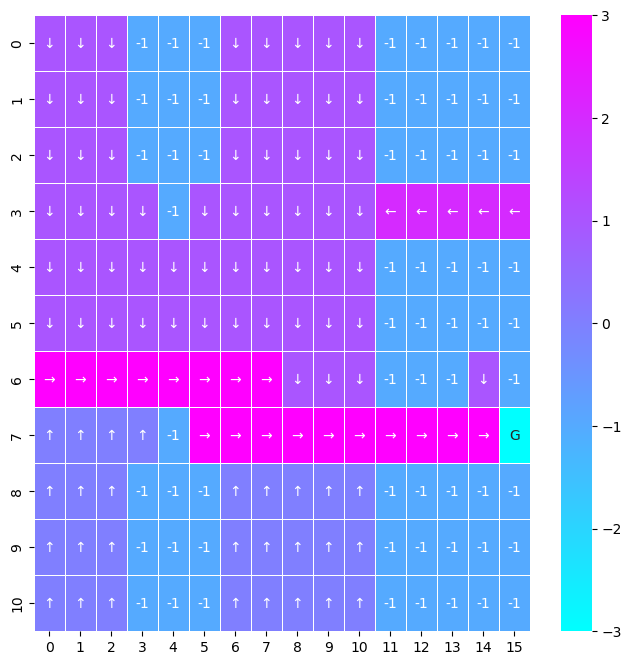

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

grid = np.zeros((11,16))
# Obstacle
grid[0:3, 3:6] = -1
grid[8:11, 3:6] = -1
grid[3, 4] = -1
grid[7, 4] = -1
grid[0:3, 11:16] = -1
grid[4:7, 11:16] = -1
grid[8:11, 11:16] = -1
grid[6, 14] = 0

# Goal
grid[7, 15] = -3

# Setting expert policy
grid[0:7, 6:11] = 1
grid[6, 14] = 1
grid[3, 3] = 1
grid[0:6, 0:3] = 1
grid[3, 5] = 1
grid[4:6, 3:6] = 1
grid[3, 11:16] = 2
grid[6, 0:8] = 3
grid[7, 5:15] = 3


num_to_arrow = {0: u'\u2191', 1: u'\u2193', 2: u'\u2190', 3: u'\u2192', -1:'-1', -3:'G'}
f = np.vectorize(lambda x: num_to_arrow[x])
arrows = f(grid)

np.save('Ocean/expert_policy.npy', grid.astype(int))

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(grid, annot=arrows, fmt="s", cmap='cool', linewidths=.5)
plt.show()



Save and load an entier model